### Building on the [Kaggle notebook](https://www.kaggle.com/code/lccburk/feature-engineering-and-random-forest-prediction) 📔, only tweaked RandomForest parameters 🌲: `n_estimators` to 125 and `min_samples_leaf` to 10. Achieved an improved leaderboard score of 0.428 👍."

# Feature Engineering and Random Forest Prediction to Detect Sleep States

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
import datetime 
from tqdm import tqdm

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from metric import score # Import event detection ap score function

# These are variables to be used by the score function
column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

## Importing data

In [17]:
# Importing data 

# Column transformations

dt_transforms = [
    pl.col('timestamp').str.to_datetime(), 
    (pl.col('timestamp').str.to_datetime().dt.year()-2000).cast(pl.UInt8).alias('year'), 
    pl.col('timestamp').str.to_datetime().dt.month().cast(pl.UInt8).alias('month'),
    pl.col('timestamp').str.to_datetime().dt.day().cast(pl.UInt8).alias('day'), 
    pl.col('timestamp').str.to_datetime().dt.hour().cast(pl.UInt8).alias('hour')
]

data_transforms = [
    pl.col('anglez').cast(pl.Int16), # Casting anglez to 16 bit integer
    (pl.col('enmo')*1000).cast(pl.UInt16), # Convert enmo to 16 bit uint
]

train_series = pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

train_events = pl.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv').with_columns(
    dt_transforms
    )

test_series = pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

# Getting series ids as a list for convenience
series_ids = train_events['series_id'].unique(maintain_order=True).to_list()
print(len(series_ids))
# Removing series with mismatched counts: 
onset_counts = train_events.filter(pl.col('event')=='onset').group_by('series_id').count().sort('series_id')['count']
wakeup_counts = train_events.filter(pl.col('event')=='wakeup').group_by('series_id').count().sort('series_id')['count']


counts = pl.DataFrame({'series_id':sorted(series_ids), 'onset_counts':onset_counts, 'wakeup_counts':wakeup_counts})
count_mismatches = counts.filter(counts['onset_counts'] != counts['wakeup_counts'])

train_series = train_series.filter(~pl.col('series_id').is_in(count_mismatches['series_id']))
train_events = train_events.filter(~pl.col('series_id').is_in(count_mismatches['series_id']))

# Updating list of series ids, not including series with no non-null values.
series_ids = train_events.drop_nulls()['series_id'].unique(maintain_order=True).to_list()
print(len(series_ids))

277
269


## Feature Engineering

In [4]:
features, feature_cols = [pl.col('hour')], ['hour']

for mins in [5, 30, 60*2, 60*8] :
    features += [
        pl.col('enmo').rolling_mean(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'enmo_{mins}m_mean'),
        pl.col('enmo').rolling_max(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'enmo_{mins}m_max')
    ]

    feature_cols += [ 
        f'enmo_{mins}m_mean', f'enmo_{mins}m_max'
    ]

    # Getting first variations
    for var in ['enmo', 'anglez'] :
        features += [
            (pl.col(var).diff().abs().rolling_mean(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
            (pl.col(var).diff().abs().rolling_max(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max')
        ]

        feature_cols += [ 
            f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max'
        ]

id_cols = ['series_id', 'step', 'timestamp']

train_series = train_series.with_columns(
    features
).select(id_cols + feature_cols)

test_series = test_series.with_columns(
    features
).select(id_cols + feature_cols)

In [5]:
def make_train_dataset(train_data, train_events, drop_nulls=False) :
    
    series_ids = train_data['series_id'].unique(maintain_order=True).to_list()
    X, y = pl.DataFrame(), pl.DataFrame()
    for idx in tqdm(series_ids) : 
        
        # Normalizing sample features
        sample = train_data.filter(pl.col('series_id')==idx).with_columns(
            [(pl.col(col) / pl.col(col).std()).cast(pl.Float32) for col in feature_cols if col != 'hour']
        )
        
        events = train_events.filter(pl.col('series_id')==idx)
        
        if drop_nulls : 
            # Removing datapoints on dates where no data was recorded
            sample = sample.filter(
                pl.col('timestamp').dt.date().is_in(events['timestamp'].dt.date())
            )
        
        X = X.vstack(sample[id_cols + feature_cols])

        onsets = events.filter((pl.col('event') == 'onset') & (pl.col('step') != None))['step'].to_list()
        wakeups = events.filter((pl.col('event') == 'wakeup') & (pl.col('step') != None))['step'].to_list()

        # NOTE: This will break if there are event series without any recorded onsets or wakeups
        y = y.vstack(sample.with_columns(
            sum([(onset <= pl.col('step')) & (pl.col('step') <= wakeup) for onset, wakeup in zip(onsets, wakeups)]).cast(pl.Boolean).alias('asleep')
            ).select('asleep')
            )
    
    y = y.to_numpy().ravel()
    
    return X, y

In [6]:
def get_events(series, classifier) :
    '''
    Takes a time series and a classifier and returns a formatted submission dataframe.
    '''
    
    series_ids = series['series_id'].unique(maintain_order=True).to_list()
    events = pl.DataFrame(schema={'series_id':str, 'step':int, 'event':str, 'score':float})

    for idx in tqdm(series_ids) : 

        # Collecting sample and normalizing features
        scale_cols = [col for col in feature_cols if (col != 'hour') & (series[col].std() !=0)]
        X = series.filter(pl.col('series_id') == idx).select(id_cols + feature_cols).with_columns(
            [(pl.col(col) / series[col].std()).cast(pl.Float32) for col in scale_cols]
        )

        # Applying classifier to get predictions and scores
        preds, probs = classifier.predict(X[feature_cols]), classifier.predict_proba(X[feature_cols])[:, 1]

        #NOTE: Considered using rolling max to get sleep periods excluding <30 min interruptions, but ended up decreasing performance
        X = X.with_columns(
            pl.lit(preds).cast(pl.Int8).alias('prediction'), 
            pl.lit(probs).alias('probability')
                        )
        
        # Getting predicted onset and wakeup time steps
        pred_onsets = X.filter(X['prediction'].diff() > 0)['step'].to_list()
        pred_wakeups = X.filter(X['prediction'].diff() < 0)['step'].to_list()
        
        if len(pred_onsets) > 0 : 
            
            # Ensuring all predicted sleep periods begin and end
            if min(pred_wakeups) < min(pred_onsets) : 
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups) :
                pred_onsets = pred_onsets[:-1]

            # Keeping sleep periods longer than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods :
                # Scoring using mean probability over period
                score = X.filter((pl.col('step') >= onset) & (pl.col('step') <= wakeup))['probability'].mean()

                # Adding sleep event to dataframe
                events = events.vstack(pl.DataFrame().with_columns(
                    pl.Series([idx, idx]).alias('series_id'), 
                    pl.Series([onset, wakeup]).alias('step'),
                    pl.Series(['onset', 'wakeup']).alias('event'),
                    pl.Series([score, score]).alias('score')
                ))

    # Adding row id column
    events = events.to_pandas().reset_index().rename(columns={'index':'row_id'})

    return events

## Training Models

In [8]:

from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(series_ids, train_size=0.7, random_state=42)

# We will collect datapoints at 10 minute intervals for training for validating
train_data = train_series.filter(pl.col('series_id').is_in(train_ids)).take_every(12 * 10).collect()
# train_data = train_series.filter(pl.col('series_id').is_in(series_ids)).collect().sample(int(1e6))
val_data = train_series.filter(pl.col('series_id').is_in(val_ids)).collect()
val_solution = train_events.filter(pl.col('series_id').is_in(val_ids)).select(['series_id', 'event', 'step']).to_pandas()
'''
# We will collect datapoints and take 1 million samples
train_data = train_series.filter(pl.col('series_id').is_in(series_ids)).collect().sample(int(1e6))
'''

"\n# We will collect datapoints and take 1 million samples\ntrain_data = train_series.filter(pl.col('series_id').is_in(series_ids)).collect().sample(int(1e6))\n"

In [9]:
# Creating train dataset
X_train, y_train = make_train_dataset(train_data, train_events)

100%|██████████| 188/188 [00:01<00:00, 104.01it/s]


### Training and validating random forest

0
20
40
60
80
100
0.9607126043552032 41


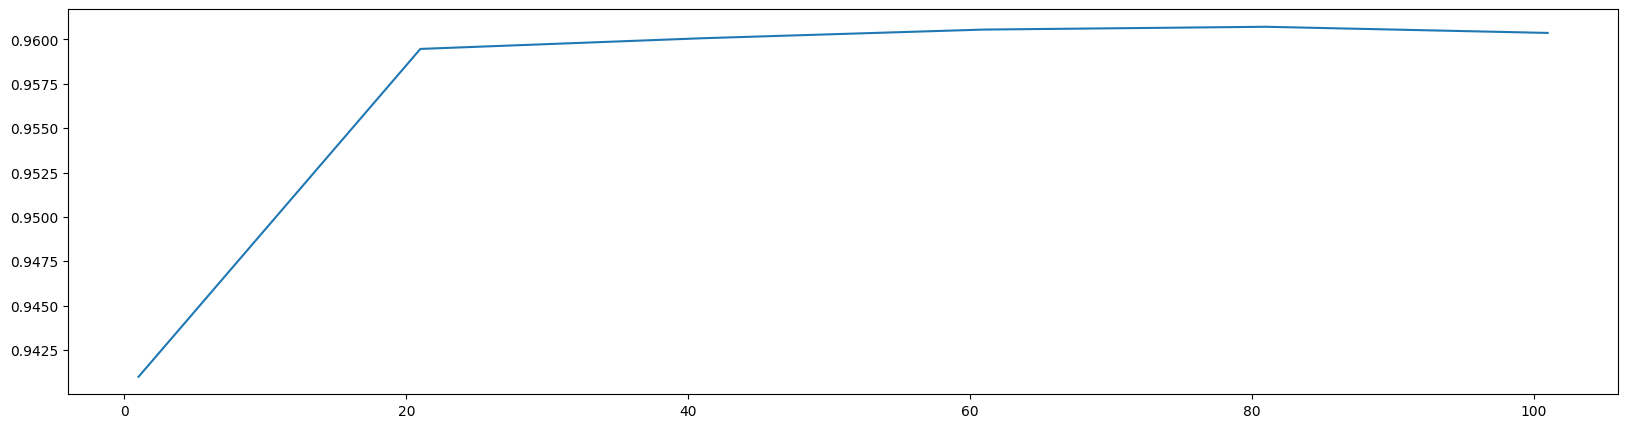

4


In [8]:
# import matplotlib.pyplot as plt
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# # n_estimator 曲线
# superpa = []
# for i in range(0,120,20):
#     print(i)
#     rfc = RandomForestClassifier(criterion = "gini"
#                                  ,n_estimators=i+1,min_samples_leaf=10
#                                  ,n_jobs=-1
#                                  ,random_state = 42
#                                 )
#     rfc_s = cross_val_score(rfc,X_train[feature_cols],y_train,cv=3).mean()
#     superpa.append(rfc_s)
# print(max(superpa),superpa.index(max(superpa))*10+1)
# plt.figure(figsize=[20,5])
# plt.plot(range(1,121,20),superpa)
# plt.show()
# print(superpa.index(max(superpa)))

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# # n_estimator 曲线
# superpa = []
# for i in range(21,26,2):
#     print(i)
#     rfc = RandomForestClassifier(criterion = "gini"
#                                  ,n_estimators=i+1
#                                  ,n_jobs=-1
#                                  ,random_state = 42
#                                 )
#     rfc_s = cross_val_score(rfc,X_train[feature_cols],y_train,cv=5).mean()
#     superpa.append(rfc_s)
# print(max(superpa),superpa.index(max(superpa))*10+1)
# plt.figure(figsize=[20,5])
# plt.plot(range(21,26),superpa)
# plt.show()
# print(superpa.index(max(superpa)))

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Training classifier
rf_classifier = RandomForestClassifier(criterion = "gini"
                                         ,n_estimators=23
                                         ,n_jobs=-1
                                         ,random_state = 42
                                         ,min_samples_leaf=10
                                      )

rf_classifier.fit(X_train[feature_cols], y_train)

RandomForestClassifier(min_samples_leaf=10, n_estimators=23, n_jobs=-1,
                       random_state=42)

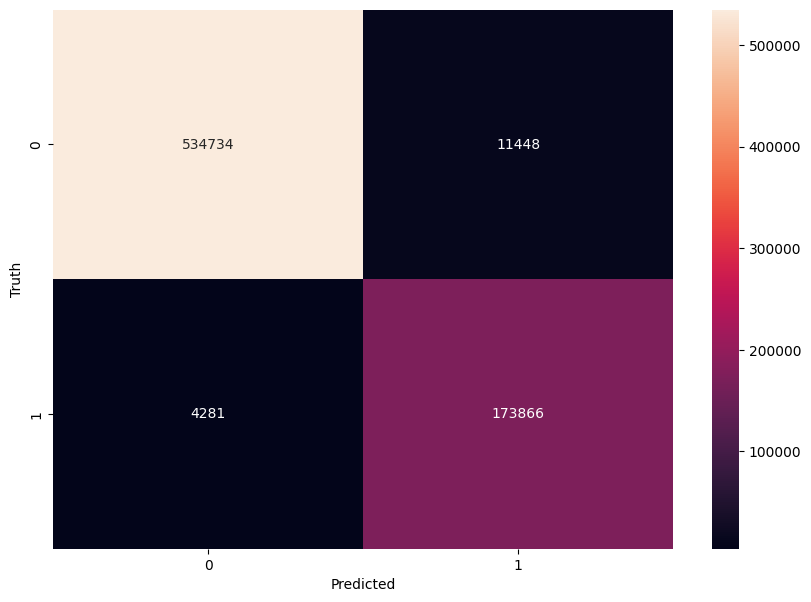

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred = rf_classifier.predict(X_train[feature_cols])

# Create confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


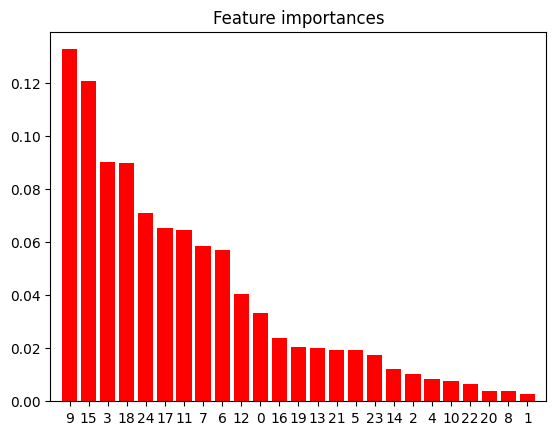

In [20]:
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train[feature_cols].shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train[feature_cols].shape[1]), indices)
plt.xlim([-1, X_train[feature_cols].shape[1]])
plt.show()


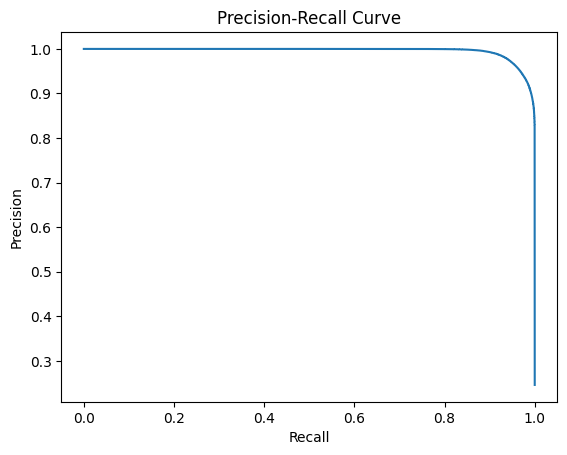

In [24]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = rf_classifier.predict_proba(X_train[feature_cols])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, y_scores)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


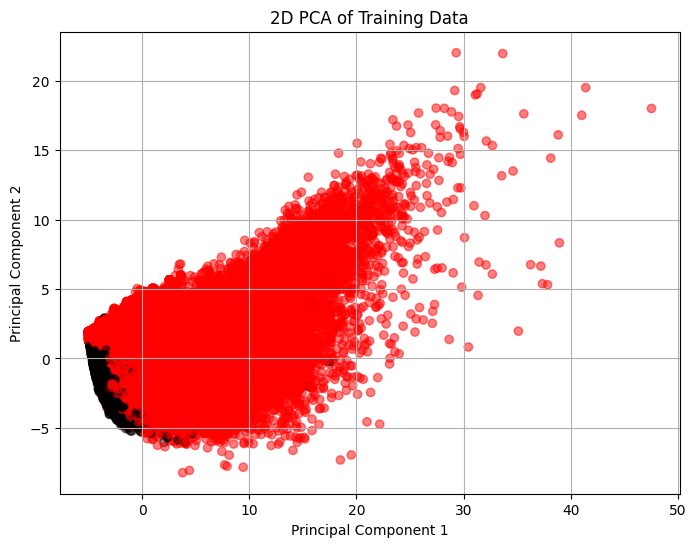

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Assuming X_train is your data and y_train is your target variable
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train[feature_cols])

# Perform PCA
pca = PCA(n_components=2)  # Reduce to two dimensions
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components and the target variable
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['target'] = y_train  # Now directly using y_train

# Plot the 2D projection with color based on target variable
plt.figure(figsize=(8, 6))
colors = {0: 'red', 1: 'black'}  # Assuming binary target with values 0 and 1
plt.scatter(pc_df['PC1'], pc_df['PC2'], alpha=.5, c=pc_df['target'].apply(lambda x: colors[x]))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Training Data')
plt.grid(True)
plt.show()


In [13]:
# Saving classifier 
import pickle
with open('rf_classifier_5m_8h.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

#with open('rf_classifier.pkl', 'rb') as f:
#    rf_classifier = pickle.load(f)

In [14]:
# Checking performance on validation set
rf_submission = get_events(val_data, rf_classifier)

print(f"Random forest score: {score(val_solution, rf_submission, tolerances, **column_names)}")

100%|██████████| 81/81 [07:02<00:00,  5.22s/it]


Random forest score: 0.26006758541015873


### Training and validating gradient boost

In [ ]:
'''# With SKL
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gb_classifier.fit(X_train[feature_cols], y_train)'''

In [ ]:
'''# Plotting feature importances
px.bar(x=feature_cols, 
       y=gb_classifier.feature_importances_,
       title='Gradient boosting feature importances'
      )'''

In [ ]:
'''
# Checking performance on validation set
gb_submission = get_events(val_data, gb_classifier)

print(f"Gradient boosting score: {score(val_solution, gb_submission, tolerances, **column_names)}")
'''

## Applying to test data

In [ ]:
# Recovering memory
del train_data 

In [ ]:
# Getting event predictions for test set and saving submission
submission = get_events(test_series.collect(), rf_classifier)
submission.to_csv('submission.csv', index=False)